In [1]:
import pandas as pd
from utils import *

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pytrends.request import TrendReq
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats

In [ ]:
@everyone die Tabelle data/new.csv enthält die Daten bisher (ich muss noch die neuen Faktoren hinzufügen, aber ein paar sind schon drin). 
Könntet ihr ein paar Plots zur Verteilung der Daten machen?
Die Spalten GINI_HND,I_IUSNET,F10_RT sind die Faktoren. Alle anderen Spalten sind die verschiedenen Verbrechen, jeweils in absolut und normiert. Ich würde die normierten nehemen, die Spalten haben jeweils die Endung _P_HTHAB, also z.B. ICCS05021_P_HTHAB.
Intentional homicide könnte interessant sein, das wäre crime code ICCS0101

ICCS0101    Mord 
ICCS0102:   versuchter Mord

ICCS020111: Schwere Körperverletzung 

ICCS020221: Entführung

ICCS0301:   Sexuelle Gewalt 
ICCS03011:  Vergewaltigung 
ICCS03012:  Sexuelle Übergriffe
ICCS0302:   Sexuelle Ausbeutung 

ICCS0401:   Raub 

ICCS0501:   Einbruch
ICCS05012:  Einbruch in private Wohnräume 

ICCS0502:   Diebstahl
ICCS05021:  Diebstahl eines motorisierten Fahrzeugs oder Teilen davon

ICCS0601:   Rechtswidrige Handlungen im Zusammenhang mit kontrollierten Drogen oder Vorläuferstoffen

ICCS0701:   Betrug 
ICCS0703:   Korruption 
ICCS07031:  Bestechung

ICCS07041:  Geldwäsche 
ICCS09051:  Beteiligung an einer organisierten kriminellen Vereinigung

ICCS0903:   Handlungen gegen Computersysteme



In [50]:

def normalize(df, column_name='metroreg'):
    delimiter = ":"
    new_column_names = [column_name, column_name + '_d']
    #print(new_column_names,'//',delimiter,'//',column_name)
    df[new_column_names] = df[column_name].str.split(delimiter, expand=True)
    
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    return df

def grouping(df, rename='value', agg='mean', cols_to_groupby=['metroreg', 'TIME_PERIOD']):
    #print(df, rename, agg, cols_to_groupby)
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    #exec(f"df = df.groupby(['metroreg', {add}]).agg({{'OBS_VALUE': {agg}}})")

    df = df.groupby(cols_to_groupby).agg({'OBS_VALUE': agg}) ##, 'geo_d': 'max'})
    df.rename(columns={'TIME_PERIOD': 'year'}, inplace=True)
    df.rename(columns={'OBS_VALUE': rename}, inplace=True)
    df = df.reset_index()
    return df

def label_metroreg(row):
    if len(row['metroreg']) == 2:
        return 'R'
    elif 'N' in row['metroreg']:
        return 'N'
    else:
        return 'M'

In [51]:
tablelist = [\
             ('dfgdp','gdp',"../raw_data/GDP_metro_10r_3gdp_linear.csv",'mean',["metroreg", "TIME_PERIOD", "unit"]), \
             ('dfarea','area',"../raw_data/Area_estat_met_d3area_en.csv",'mean',["metroreg", "TIME_PERIOD"]), \
             #('dfhtec','htec',"../raw_data/HighTec_patents_met_pat_eptec_linear.csv",'mean'), \
             ('dfpop','population',"../raw_data/Population_met_pjangrp3_linear.csv",'mean',["metroreg", "TIME_PERIOD"\
                                                                                           # , "dfpop_sex", "dfpop_age"
                                                                                           ]), \
             ('dfunemp','unemp per Tsd.',"../raw_data/Unemployment_met_lfu3pers_linear.csv",'mean',["metroreg", "TIME_PERIOD", "dfunemp_sex", "dfunemp_age"]),\
             ('dfcrime','Nr_Crimes',"../raw_data/Crime_in_Metropoles_estat_met_crim_gen_en.csv",'sum',["metroreg", "TIME_PERIOD", "iccs"])]

#Nachschauen worauf sich d_alc der Wert bezieht!!!!
## Wie wird poverty das gemessen?????
for dataframe, name, value, agg, add in tablelist:
    exec(f"{dataframe} = pd.read_csv('{value}')")
    #exec(f"print('{dataframe}', len({dataframe}) )")   
    #exec(f"print({dataframe})")

dfarea  = dfarea.loc[dfarea ['landuse'] == 'TOTAL:Total area']
dfcrime = dfcrime[dfcrime['unit'].str.startswith('NR:Number')]

dfpop = dfpop.loc[dfpop ['sex'] == 'T:Total']
dfpop   = dfpop[dfpop['age'].str.startswith('TOTAL:Total')]
#dfpop.rename(columns={'sex': 'dfpop_sex'}, inplace=True)
#dfpop.rename(columns={'age': 'dfpop_age'}, inplace=True)

#dfgdp = dfgdp[dfgdp['unit'].str.startswith('EUR_HAB:')]
#['Y15-24:From 15 to 24 years' 'Y15-29:From 15 to 29 years' 'Y15-74:From 15 to 74 years' 'Y20-64:From 20 to 64 years' 'Y_GE15:15 years or over' 'Y_GE25:25 years or over']

dfunemp = dfunemp.loc[dfunemp['sex'].isin(['M:Males', 'T:Total'])]
#dfunemp = dfunemp[dfunemp['age'].str.startswith('Y15-74' or 'Y15-29')]
prefixes = ['Y15-74', 'Y15-2']
dfunemp = dfunemp[dfunemp['age'].str.startswith(tuple(prefixes))]

dfunemp.rename(columns={'sex': 'dfunemp_sex'}, inplace=True)
dfunemp.rename(columns={'age': 'dfunemp_age'}, inplace=True)
dfunemp.rename(columns={'unit': 'dfunemp_unit'}, inplace=True)

dfall = dfarea
dfall = dfall.reset_index()
dfall.drop(columns=dfall.columns.difference(['metroreg', 'TIME_PERIOD']), axis=1, inplace=True)


for dataframe, name, value, agg, add in tablelist:
    exec(f"{dataframe} = grouping({dataframe}, '{name}', '{agg}', {add})")
    #exec(f"print(dfall.dtypes)")
    #exec(f"print({dataframe}.dtypes)")
    exec(f"dfall = pd.merge(dfall, {dataframe}, on=['metroreg', 'TIME_PERIOD'], how='inner')")

dfall = normalize(dfall)
dfall['metroreg_type'] = dfall.apply(label_metroreg, axis=1)
dfall = normalize(dfall,'iccs')

print(dfall)

dfall.to_csv('../data/df_allmetro_all.csv', index=False)

       metroreg  TIME_PERIOD  \
0            AT         2014   
1            AT         2014   
2            AT         2014   
3            AT         2014   
4            AT         2014   
...         ...          ...   
137559       TR         2020   
137560       TR         2020   
137561       TR         2020   
137562       TR         2020   
137563       TR         2020   

                                                     unit      gdp      area  \
0                             EUR_HAB:Euro per inhabitant  39000.0   83882.0   
1                             EUR_HAB:Euro per inhabitant  39000.0   83882.0   
2                             EUR_HAB:Euro per inhabitant  39000.0   83882.0   
3                             EUR_HAB:Euro per inhabitant  39000.0   83882.0   
4                             EUR_HAB:Euro per inhabitant  39000.0   83882.0   
...                                                   ...      ...       ...   
137559  PPS_HAB_EU27_2020:Purchasing power standard (P.

In [78]:
dfout = dfall
dfout = dfout.loc[dfout['metroreg_type'].isin(['M', 'N'])]
dfout.dropna(subset=['unemp per Tsd.'], inplace=True)
dfout.dropna(subset=['Nr_Crimes'], inplace=True)
dfout = dfout.loc[dfout['TIME_PERIOD'] < 2020]
dfout = dfout[dfout['dfunemp_age'].str.startswith('Y15-2')]
dfout = dfout.loc[dfout['dfunemp_sex'] == 'M:Males']
dfout['dfunemp_rate_youth'] = dfout['unemp per Tsd.'] * 1000 * 100 / dfout['population']
dfout['dfcrimes_rate_all'] = dfout['Nr_Crimes'] * 1000 * 100 / dfout['population']
dfout = dfout.loc[dfout['unit'] == 'EUR_HAB:Euro per inhabitant']
dfout

print(dfout['dfunemp_age'].unique())
print(len(dfout))
#print(dfgdp[dfgdp["metroreg"].str.startswith('AT')])
#print(dfarea[dfarea["metroreg"].str.startswith('AT')])
#print(dfpop[dfpop["metroreg"].str.startswith('AT')])
#print(dfunemp[dfunemp["metroreg"].str.startswith('AT')])
#print(dfcrime[dfcrime["metroreg"].str.startswith('AT')])
#print(dfall[dfall["metroreg"].str.startswith('AT')])
#print(dfout[dfout["metroreg"].str.startswith('BE')])

['Y15-24:From 15 to 24 years' 'Y15-29:From 15 to 29 years']
2420


C:\Users\zmugm1\AppData\Local\Temp\ipykernel_7744\2175480438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.dropna(subset=['unemp per Tsd.'], inplace=True)
C:\Users\zmugm1\AppData\Local\Temp\ipykernel_7744\2175480438.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.dropna(subset=['Nr_Crimes'], inplace=True)


In [83]:
print(dfout['iccs'].unique(), dfout['iccs_d'].unique())
#dfplot = dfout[dfout['metroreg'].str.startswith('AT')]
dfout = dfout[dfout['iccs'].str.startswith('ICCS05012')]
#dfplot

['ICCS0101' 'ICCS0401' 'ICCS05012' 'ICCS050211'] ['Intentional homicide' 'Robbery'
 'Burglary of private residential premises'
 'Theft of a motorized land vehicle']


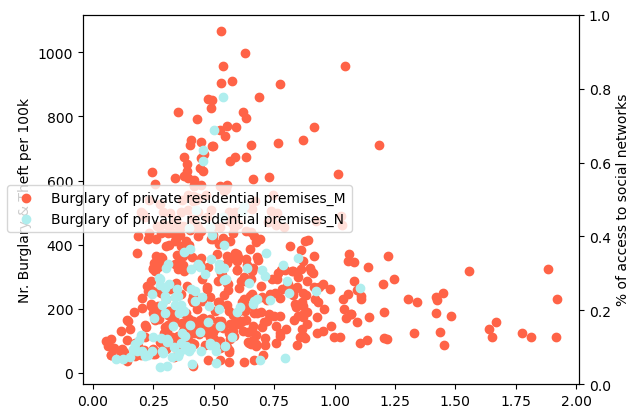

[4.21946725e-05] 0.5440680089729844
[-6.14924205e-05] 0.6021333032121966
[0.00038537] 0.35188786851934206
PearsonRResult(statistic=-0.03875068279309304, pvalue=0.3872321983362266)
PearsonRResult(statistic=0.3420426835143565, pvalue=0.00018297596894446442)
Burglary/Theft vs access to soc. networks: TtestResult(statistic=33.76551103793891, pvalue=2.62786414354564e-167, df=998.0)
Burglary/Theft vs access to soc. networks: TtestResult(statistic=14.868482976389524, pvalue=2.065552031845314e-35, df=228.0)


In [84]:
dfout2 = dfout[dfout['metroreg_type']=='N']
#print(dfout2)
dfout1 = dfout[dfout['metroreg_type']=='M']
#dfplot = dfout[dfout['metroreg'].str.startswith('AT')]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax1.scatter(dfout['TIME_PERIOD'], dfout['dfcrimes_rate_all'], color='tomato', label='Burglaries and Thefts')
ax1.scatter(dfout1['dfunemp_rate_youth'], dfout1['dfcrimes_rate_all'], color='tomato', label=max(dfout1['iccs_d'])+'_M')
ax1.scatter(dfout2['dfunemp_rate_youth'], dfout2['dfcrimes_rate_all'], color='paleturquoise', label=max(dfout2['iccs_d'])+'_N')
#ax1.plot(dfout3['TIME_PERIOD'], dfout3['Nr_Crimes'], color='moccasin', label=max(dfout3['iccs_d']))
#ax1.plot(dfout4['TIME_PERIOD'], dfout4['Nr_Crimes'], color='deepskyblue', label=max(dfout4['iccs_d']))
#plt.plot(df[df['name'] == 'John']['age'], label='John')
#ax2.plot(dfout['TIME_PERIOD'], dfout['socnet'], color='lightgreen', label='% attending social networks')
#ax2.plot(dfout1['TIME_PERIOD'], dfout1['dfunemp_rate_youth'], color='lightgreen', label='unemployment rate')
#ax2.scatter(dfout['TIME_PERIOD'], dfout['gini'], color='darkgoldenrod', label='Gini-Index')

#ax1.set_title('Scatter Plot with Two Lines')
#ax1.set_xlabel('X-axis')
ax1.set_ylabel('Nr. Burglary & Theft per 100k')
ax2.set_ylabel('% of access to social networks')

plt.title('')
#plt.ylabel('GDP per capita')
fig.legend(loc=6)
plt.show()


model = LinearRegression().fit(dfout[["dfcrimes_rate_all"]],dfout["dfunemp_rate_youth"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)
model = LinearRegression().fit(dfout1[["dfcrimes_rate_all"]],dfout1["dfunemp_rate_youth"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)
model = LinearRegression().fit(dfout2[["dfcrimes_rate_all"]],dfout2["dfunemp_rate_youth"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)

print(stats.pearsonr(dfout1['dfcrimes_rate_all'],dfout1['dfunemp_rate_youth']))
print(stats.pearsonr(dfout2['dfcrimes_rate_all'],dfout2['dfunemp_rate_youth']))
print(f"crime rate vs youth unemp rate: {stats.ttest_ind(dfout1['dfcrimes_rate_all'],dfout1['dfunemp_rate_youth'])}")
print(f"crime rate vs youth unemp rate: {stats.ttest_ind(dfout2['dfcrimes_rate_all'],dfout2['dfunemp_rate_youth'])}")

In [96]:
dfgini = pd.read_csv("../raw_data/Unemployment_met_lfu3pers_linear.csv")
#dfgini = pd.read_csv("../raw_data/ICT_Usage_isoc_ci_ac_i_linear.csv")
#dfgini = pd.read_csv("../raw_data/Crime_in_Metropoles_estat_met_crim_gen_en.csv")
#dfgini[['geo', 'geo_d']] = dfgini['geo'].str.split(':', expand=True)
dfgini = dfgini[dfgini['metroreg'].str.startswith('DE')]
#dfgini = dfgini[dfgini['iccs'].str.startswith('ICCS050211')]
#dfgini = dfgini.loc[dfgini['TIME_PERIOD'] > 2015]
    #dfgini = dfgini.loc[dfgini['TIME_PERIOD'] == 2015 ]
#dfgini.dropna(subset=['OBS_VALUE'], inplace=True)

print(dfgini.dtypes)
print(dfgini['sex'].unique())
print(dfgini['age'].unique())
#dfgini

DATAFLOW        object
LAST UPDATE     object
freq            object
unit            object
age             object
sex             object
metroreg        object
TIME_PERIOD      int64
OBS_VALUE      float64
OBS_FLAG        object
dtype: object
['F:Females' 'M:Males' 'T:Total']
['Y15-24:From 15 to 24 years' 'Y15-29:From 15 to 29 years'
 'Y15-74:From 15 to 74 years' 'Y20-64:From 20 to 64 years'
 'Y_GE15:15 years or over' 'Y_GE25:25 years or over']


In [97]:

def normalize1(df, column_name='geo'):
    delimiter = ":"
    new_column_names = [column_name, column_name + '_d']
    #print(new_column_names,'//',delimiter,'//',column_name)
    df[new_column_names] = df[column_name].str.split(delimiter, expand=True)
    
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    return df

def grouping1(df, rename='value', agg='mean'):
    #print(df, rename, agg, cols_to_groupby)
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    #exec(f"df = df.groupby(['metroreg', {add}]).agg({{'OBS_VALUE': {agg}}})")
    cols_to_groupby=['geo', 'TIME_PERIOD']
    df = df.groupby(cols_to_groupby).agg({'OBS_VALUE': agg}) ##, 'geo_d': 'max'})
    df.rename(columns={'TIME_PERIOD': 'year'}, inplace=True)
    df.rename(columns={'OBS_VALUE': rename}, inplace=True)
    df = df.reset_index()
    return df


tablelist = [\
          ('dfalc_b','d_alc',"../raw_data/Archive/Death_to_alcoholic_abuse_tps00140_linear.csv",'mean'), \
           ('dfgini_b','gini',"../raw_data/Archive/Gini_index_tessi190_linear.csv",'mean'), \
           ('dfhealthage_b','h_age',"../raw_data/Archive/Healthy_life_years_hlth_hlye_linear.csv",'mean'), \
           ('dfsocnet_b','socnet',"../raw_data/Archive/Participation_in_social_networks_testat_tin00127_en.csv",'mean'), \
           #('dfcrime','dfcrime',"Crimes_per_100tsd_estat_crim_off_cat_en.csv"),
           ('dfpoverty_b','poverty',"../raw_data/Archive/People_risk_poverty_or_social_exclusion_sdg_01_10_linear.csv",'mean'), \
           ('dfunemp_b','unemp',"../raw_data/Archive/Unemployment_rate_tipsun20_linear.csv",'mean')]

#Nachschauen worauf sich d_alc der Wert bezieht!!!!
## Wie wird poverty das gemessen?????
for dataframe, name, value, agg in tablelist:
    exec(f"{dataframe} = pd.read_csv('{value}')")
    #exec(f"print('{dataframe}', len({dataframe}) )")   
    #exec(f"print({dataframe})")

dfalc_b  = dfalc_b.loc[dfalc_b ['sex'] == 'T:Total']
dfhealthage_b = dfhealthage_b.loc[dfhealthage_b ['sex'] == 'T:Total']
dfhealthage_b = dfhealthage_b[dfhealthage_b['indic_he'].str.startswith('HLY_PC_0')]
dfpoverty_b   = dfpoverty_b[dfpoverty_b['age'].str.startswith('TOTAL:Total')]
dfpoverty_b   = dfpoverty_b[dfpoverty_b['unit'].str.startswith('PC:Percentage')]                      
dfunemp_b     = dfunemp_b[dfunemp_b['unit'].str.startswith('PC_ACT')]     
dfunemp_b     = dfunemp_b[dfunemp_b['age'].str.startswith('Y25-74')]

#for dataframe, name, value, agg in tablelist:
#    exec(f"print('{dataframe}', len({dataframe}) )")   

dfall_b = dfalc_b
dfall_b = dfall_b.reset_index()
dfall_b.drop(columns=dfall_b.columns.difference(['geo', 'TIME_PERIOD']), axis=1, inplace=True)
#print(dfall_b)

for dataframe, name, value, agg in tablelist:
    exec(f"{dataframe} = grouping1({dataframe}, '{name}', '{agg}')")
    exec(f"dfall_b = pd.merge(dfall_b, {dataframe}, on=['geo', 'TIME_PERIOD'], how='outer')")

dfcrime1 = pd.read_csv("../raw_data/Archive/Crimes_per_100tsd_estat_crim_off_cat_en.csv")
dfcrime1.rename(columns={'OBS_VALUE': 'Nr_Crimes'}, inplace=True)
dfcrime1 = dfcrime1[dfcrime1['unit'].str.startswith('P_HTHAB')]
#dfcrime = dfcrime[dfcrime['iccs'].str.startswith('ICCS0101')\
                  #|dfcrime['iccs'].str.startswith('ICCS03')\
#                 ]
#dfcrime = dfcrime.groupby(['geo', 'TIME_PERIOD'])['Nr_Crimes'].sum()
dfcrime1 = dfcrime1.groupby(['geo', 'TIME_PERIOD', 'iccs'])['Nr_Crimes'].sum()
dfcrime1 = dfcrime1.reset_index()
dfcrime1 = normalize1(dfcrime1)
dfcrime1.drop('geo_d', axis=1, inplace=True)
dfcrime1 = normalize1(dfcrime1,'iccs')

dfall_b = normalize1(dfall_b)
dfall_b = pd.merge(dfall_b, dfcrime1, on=['geo', 'TIME_PERIOD'], how='inner')
dfall_b.to_csv('../data/df_all.csv', index=False)

#print(dfall_b)

#print(dfcrime['iccs'].unique())

['ICCS0101' 'ICCS0102' 'ICCS020111' 'ICCS020221' 'ICCS03011' 'ICCS03012'
 'ICCS0301' 'ICCS0302' 'ICCS0401' 'ICCS05012' 'ICCS05021' 'ICCS0502'
 'ICCS0601' 'ICCS0701' 'ICCS07031' 'ICCS0703' 'ICCS07041' 'ICCS0903'
 'ICCS09051' 'ICCS0501'] ['Intentional homicide' 'Attempted intentional homicide' 'Serious assault'
 'Kidnapping' 'Rape' 'Sexual assault' 'Sexual violence'
 'Sexual exploitation' 'Robbery'
 'Burglary of private residential premises'
 'Theft of a motorized vehicle or parts thereof' 'Theft'
 'Unlawful acts involving controlled drugs or precursors' 'Fraud'
 'Bribery' 'Corruption' 'Money laundering' 'Acts against computer systems'
 'Participation in an organized criminal group' 'Burglary']


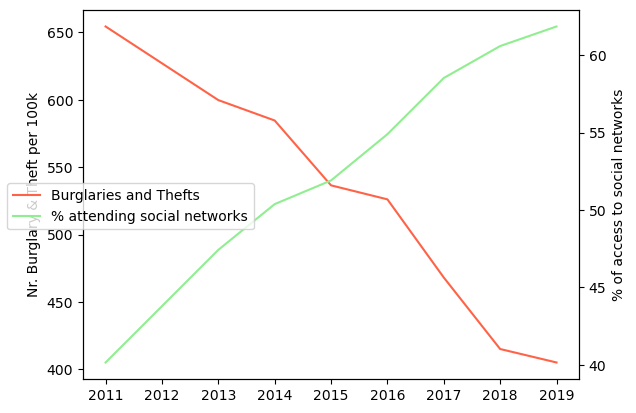

[-0.0799169] 95.07472647377455
[-0.0799169] 95.07472647377455
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
2.230807350732441
46.74089315411503
0.9522728985221361
PearsonRResult(statistic=-0.9758447102496052, pvalue=3.459994823069384e-05)
Burglary/Theft vs access to soc. networks: TtestResult(statistic=14.861435581778561, pvalue=5.754011005638378e-10, df=14.0)


In [101]:
dfout = dfall_b
print(dfout['iccs'].unique(), dfout['iccs_d'].unique())
dfout.dropna(subset=['socnet'], inplace=True)
dfout.dropna(subset=['Nr_Crimes'], inplace=True)
#dfout.dropna(subset=['gini'], inplace=True)
dfout = dfout.loc[dfout['TIME_PERIOD'] < 2020]
dfout = dfout[dfout['iccs'].str.startswith('ICCS05')\
                  #|dfout['iccs'].str.startswith('ICCS03')\
                 ]
#dfout = dfout.groupby(['geo', 'TIME_PERIOD'])[['Nr_Crimes'],['gini']].sum()
dfout = dfout.groupby([#'geo', 
                       'TIME_PERIOD' 
                       #, 'iccs' , 'iccs_d'
                        ]).agg({  'Nr_Crimes': 'mean'#})
                                            , 'gini'     : 'mean'
                                            , 'socnet'   : 'mean'
                                            , 'unemp'   : 'mean'
                                            })
dfout = dfout.reset_index()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dfout['TIME_PERIOD'], dfout['Nr_Crimes'], color='tomato', label='Burglaries and Thefts')
#ax1.plot(dfout1['TIME_PERIOD'], dfout1['Nr_Crimes'], color='tomato', label=max(dfout1['iccs_d']))
#ax1.plot(dfout2['TIME_PERIOD'], dfout2['Nr_Crimes'], color='paleturquoise', label=max(dfout2['iccs_d']))
#ax1.plot(dfout3['TIME_PERIOD'], dfout3['Nr_Crimes'], color='moccasin', label=max(dfout3['iccs_d']))
#ax1.plot(dfout4['TIME_PERIOD'], dfout4['Nr_Crimes'], color='deepskyblue', label=max(dfout4['iccs_d']))
#plt.plot(df[df['name'] == 'John']['age'], label='John')
ax2.plot(dfout['TIME_PERIOD'], dfout['socnet'], color='lightgreen', label='% attending social networks')
#ax2.plot(dfout['TIME_PERIOD'], dfout['unemp'], color='lightgreen', label='unemployment rate')
#ax2.scatter(dfout['TIME_PERIOD'], dfout['gini'], color='darkgoldenrod', label='Gini-Index')

#ax1.set_title('Scatter Plot with Two Lines')
#ax1.set_xlabel('X-axis')
ax1.set_ylabel('Nr. Burglary & Theft per 100k')
ax2.set_ylabel('% of access to social networks')

plt.title('')
#plt.ylabel('GDP per capita')
fig.legend(loc=6)
plt.show()


model = LinearRegression().fit(dfout[["Nr_Crimes"]],dfout["socnet"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)

#ICCS0903
#die Tabelle data/new.csv enthält die Daten bisher (ich muss noch die neuen Faktoren hinzufügen, aber ein paar sind schon drin). 
#Könntet ihr ein paar Plots zur Verteilung der Daten machen?
#Die Spalten GINI_HND,I_IUSNET,F10_RT sind die Faktoren. Alle anderen Spalten sind die verschiedenen Verbrechen, jeweils in absolut und normiert. Ich würde die normierten nehemen, die Spalten haben jeweils die Endung _P_HTHAB, also z.B. ICCS05021_P_HTHAB.
#Intentional homicide könnte interessant sein, das wäre crime code ICCS0101. 

print(model.coef_, model.intercept_) 
print(model.get_params())
prediction = model.predict(dfout[["Nr_Crimes"]]) # Predict the social impact
residual = dfout["socnet"] - prediction # Calculate the residual
print(np.var(residual))
print(np.var(dfout["socnet"]))
print(1 - np.var(residual) / np.var(dfout["socnet"])) 

pearson_soc_burglary = stats.pearsonr(dfout['Nr_Crimes'],dfout['socnet'])
print(pearson_soc_burglary)
print(f"Burglary/Theft vs access to soc. networks: {stats.ttest_ind(dfout['Nr_Crimes'],dfout['socnet'])}")

95% conf. interval: [-0.08383171 -0.07562755]
standard error: 2.087563031511333e-05


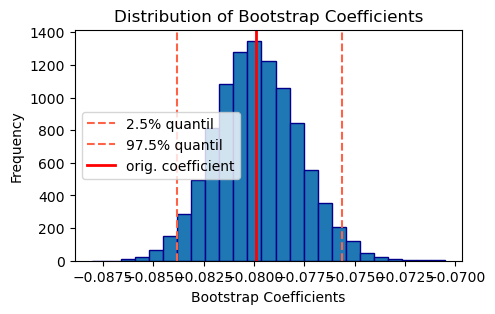

In [102]:
# Your Code goes here!
multi_sample_bs_model_coef = []
for i in range(10000):
    # resample the data
    sampled_users = dfout.sample(100, replace=True)
    # fit the model
    multi_sample_bs_model = LinearRegression()
    multi_sample_bs_model.fit(sampled_users[["Nr_Crimes"]], sampled_users["socnet"])
    # append the coefficient to the multi_sample_bs_model_coef list
    multi_sample_bs_model_coef.append(multi_sample_bs_model.coef_[0])
multi_sample_bs_model_coef = np.array(multi_sample_bs_model_coef) # Convert to array for simpler use later

confidence_interval = np.percentile(multi_sample_bs_model_coef, [2.5, 97.5])
print("95% conf. interval:", confidence_interval)

standard_error = np.std(multi_sample_bs_model_coef) / np.sqrt(len(multi_sample_bs_model_coef))
print("standard error:", standard_error)

fig, ax = plt.subplots(1, 1,  figsize=(5,3))
ax.hist(multi_sample_bs_model_coef, bins=25, edgecolor='darkblue') 
ax.set_title("Distribution of Bootstrap Coefficients")
ax.set_xlabel("Bootstrap Coefficients")
ax.set_ylabel("Frequency")

ax.axvline(confidence_interval[0], color="tomato", linestyle='dashed', label='2.5% quantil')
ax.axvline(confidence_interval[1], color="tomato", linestyle='dashed', label='97.5% quantil')
ax.axvline(model.coef_, color="red", linewidth=2, label='orig. coefficient')
ax.legend(loc=6)